In [122]:
import logging
import pandas as pd
import numpy as np
from numpy import random
import nltk
import scikitplot as skplt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
import re
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns
sns.set_style('ticks')

nltk.download('stopwords')	
nltk.download('rslp')	
nltk.download('punkt')	

%matplotlib inline

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/antonio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to /home/antonio/nltk_data...
[nltk_data]   Package rslp is already up-to-date!
[nltk_data] Downloading package punkt to /home/antonio/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
df = pd.read_csv('../crawler/dataset.csv')
df.head(10)

,title,category,description
0,Notebook Acer Aspire 5 A515-52-56A8 Intel Core...,Notebook,Cor Prata (partes A e C). Preto (partes B e D)...
1,Notebook Acer Aspire 5 A515-52G-522Z Intel Cor...,Notebook,Aspire 5 A515-52G-522Z - Processador Intel® Co...
2,Tela P/ Notebook Acer Aspire Es1-431-P0v7 14”...,Notebook,Enviamos Sua Tela Para Notebook Acer Aspire E...
3,Notebook Lenovo B330s-15ikbr Core I5 8250u 8gb...,Notebook,Lenovo B330s acessível e confiável. Acabament...
4,"Notebook Lenovo Ideapad 330 - Tela 15.6'' HD, ...",Notebook,alt='' style='width: 500px; height: 364px;'>
5,Teclado Notebook Acer Aspire E5-571,Notebook,Imagens meramente ilustrativas
6,GigabyteAorus 15,Notebook,» Valores deste anúncio exclusivamente para ...
7,Notebook Acer Aspire A515-51-C2TQ - Tela 15.6'...,Notebook,Dimensões do produto: 381.8 x 263 x 21.6 mm
8,GigabyteAorus 15,Notebook,» Valores deste anúncio exclusivamente para ...
9,Msigs65,Notebook,» Valores deste anúncio exclusivamente para ...


Each row of the dataset contains the **title, category and description**.

In [3]:
print('Approximate number of words in the dataset(non-unique): [%d]' %
      df['description'].apply(lambda x: len(x.split(' '))).sum())

Approximate number of words in the dataset(non-unique): [1975812]


Let's check the distribution of the classes.

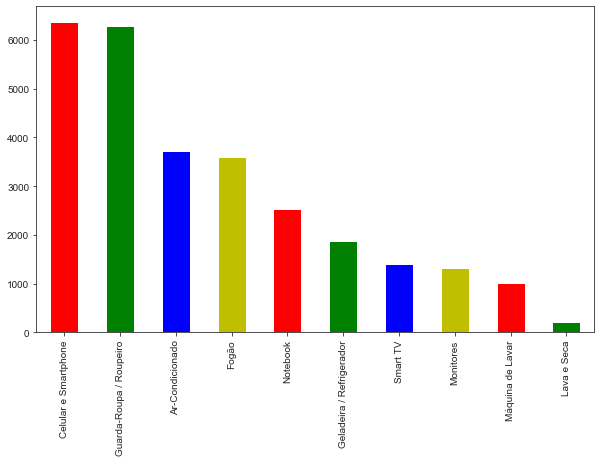

In [4]:
plt.figure(figsize=(10,6))
df.category.value_counts().plot(kind='bar', label='category', stacked=True, color=['r', 'g', 'b', 'y']);

As we can see the data is very unbalanced, so we are going to balance it using the class with minimum number of samples.

## Cleaning the data

In [5]:
from nltk.stem.rslp import RSLPStemmer
from nltk.tokenize import word_tokenize
from unicodedata import normalize

stop_words = set(stopwords.words('portuguese'))
# stemmer for portugues language
stemmer = RSLPStemmer()

punctuation = """\!\"\#\$\%\&\'\(\)\*\+\,\-\.\/\:\;\<\=\>\?[\]\^\_\`\{\|\}~"""

# Defining cleaning regexes
number_re = re.compile(r'(\d+)', re.I | re.M | re.U)
punkt_re = re.compile(r'([%s])' % punctuation, re.I | re.M | re.U)
whitespaces_re = re.compile(r'(\s)', re.I | re.M | re.U)
terms_re = re.compile(r'(garantia|fornecedor|frete|meses|desconto)', re.I | re.M | re.U)
html_re = re.compile('<.*?>', re.I | re.M | re.U)

def clean_data(text, stem=False):
    """
        text: a string

        return: modified initial string
    """
    if type(text) != str:
        raise Exception('Doc is not text data')

    # Making a copy of the original textument
    _text = text

    # Stripping
    _text = _text.strip()

    # lower case
    _text = _text.lower()

    # removing numbers
    _text = number_re.sub('', _text)
    
    # removing context terms
    _text = terms_re.sub('', _text)
    
    # removing html tags
    _text = html_re.sub('', _text)

    # removing long white spaces to single space
    _text = whitespaces_re.sub(' ', _text)

    # removing special charcters
    _text = normalize('NFKD', _text).encode('ASCII', 'ignore').decode('ASCII')
    
    # Removing stopwords and words that aren't four units long
    tokens = [
        token for token in word_tokenize(_text)
        if (token not in stop_words and len(token) > 4 and '\\' not in token)
    ]
    if stem:
        _text = ' '.join([stemmer.stem(word) for word in tokens])
    else:
        _text = ' '.join([word for word in tokens])

    return _text

In [6]:
# Merging the two text data into one so we have all the descriptive text that defines a category
df['text'] = df['title'] + ' ' + df['description']
# cleaning the new text data
df.text = df.text.apply(clean_data, stem=False)
df.category = df.category.apply(lambda category: category.strip())

Data example below

In [7]:
df = df.drop(['title', 'description'], axis=1)
df.head(-10)

,category,text
0,Notebook,notebook aspire intel ageracao memoria windows...
1,Notebook,notebook aspire a-g-z intel geracao geforce as...
2,Notebook,notebook aspire neide notebook enviamos notebo...
3,Notebook,notebook lenovo bs-ikbr radeon windows preto l...
4,Notebook,notebook lenovo ideapad intel intel graphics s...
...,...,...
28315,Celular e Smartphone,pelicula flexivel samsung galaxy prime grand p...
28316,Celular e Smartphone,carteira cover zenfone maston carteira cover z...
28317,Celular e Smartphone,carregador portatil pineng compativel motorola...
28318,Celular e Smartphone,smartphone zenfone qualcomm snapdragon camera ...


In [8]:
print('Number of words after pre-processing: [%d]' %
      df['text'].apply(lambda x: len(x.split(' '))).sum())

Number of words after pre-processing: [982309]


# Classification Models

## Multinomial Naive Bayes

### The Algorithm
The algorithm it is very statistical based using prior and posterior probabilities of the classes in the dataset.

Using the Bayes' Theorem below as the main idea:

$$P(A | B)P(B) = P(A \cap B) = P(B \cap A) = P(B | A)P(A)$$

$$P(A | B) = \frac{P(B | A)P(A)}{P(B)}$$


Now using the theorem we can ask what is the probability of a given class given that a specific document happened.

$$p(\text{class} \mid \mathbf {\text{data}} )={\frac {p(\mathbf {\text{data}} \mid \text{class}) * p(\text{class})}{p(\mathbf {\text{data}} )}}$$

where:


* $p(class | data)$ is called the posterior.
* $p(data | class)$ is called the likelihood.
* $p(class)$ is called the prior.
* $p(data)$ is called the marginal probability.


The equation above describes the full Bayes algorithm but some probabilites are very non pratical to calculate an example of this is the $P(data)$ because if we have a never seen document in the dataset this $P(data)$ is going to be $0$, so usually we don't calculate the marginal probabilities in real word cases.






**The term Naive comes from assuming that the variables are independent of each other when they may not be**

**The Multinomial is because we are not using the standard gaussian distribution but the multinomial distribution to calculate the likelihood probabilities**

This classifier is good for cases where the data are typically represented as word vector counts, although tf-idf vectors are also known to work well in practice.

Under sampling results

In [9]:
from sklearn.preprocessing import label_binarize

X = df.text
y = df.category

categories = np.unique(y)
y = label_binarize(y, classes=categories)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

The next steps includes feature engineering. We will convert our text documents to a matrix of token counts (CountVectorizer), then transform a count matrix to a normalized tf-idf representation (tf-idf transformer). After that, we train several classifiers.

In [10]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
# We use OneVsRestClassifier for multi-label prediction
from sklearn.multiclass import OneVsRestClassifier


def train_MNB(X_train, y_train, onevsrest=True):
    clf = OneVsRestClassifier(MultinomialNB()) if onevsrest else MultinomialNB()
    nb = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('clf', clf),
                   ])
    nb.fit(X_train, y_train)
    
    return nb

Now we are going to train the model and evaluate it's predicitions

In [11]:
%%time
from sklearn.metrics import classification_report

nb = train_MNB(X_train, y_train)

y_pred = nb.predict(X_test)
y_probs = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

accuracy 0.9132839157547947
                          precision    recall  f1-score   support

         Ar-Condicionado       0.99      0.97      0.98      1110
    Celular e Smartphone       0.99      0.98      0.99      1924
                   Fogão       0.99      0.98      0.99      1082
Geladeira / Refrigerador       0.97      0.82      0.89       546
 Guarda-Roupa / Roupeiro       0.99      1.00      1.00      1895
             Lava e Seca       0.33      0.01      0.03        69
               Monitores       0.98      0.58      0.73       390
        Máquina de Lavar       0.92      0.55      0.69       311
                Notebook       0.99      0.95      0.97       747
                Smart TV       0.98      0.73      0.84       425

               micro avg       0.99      0.92      0.95      8499
               macro avg       0.91      0.76      0.81      8499
            weighted avg       0.98      0.92      0.94      8499
             samples avg       0.91      0.92 

In [12]:
majority_class = df.category.mode()[0]
print('Majority Class: %s' % majority_class)

Majority Class: Celular e Smartphone


## MultinomialNB Model Evaluation

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve, average_precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import auc

# For each class
precision = dict()
recall = dict()
average_precision = dict()

for i, category in enumerate(categories):    
    precision[category], recall[category], _ = precision_recall_curve(y_test[:, i], y_probs[:, i])
    average_precision[category] = average_precision_score(y_test[:, i], y_probs[:, i])    

# A "micro-average": quantifying score on all classes jointly
precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(),
    y_probs.ravel())
average_precision["micro"] = average_precision_score(y_test, y_probs,
                                                     average="micro")
print('Average precision score, micro-averaged over all classes: {0:0.2f}'
      .format(average_precision["micro"]))

Average precision score, micro-averaged over all classes: 0.99


Plot Precision-Recall curve for each class and iso-f1 curves

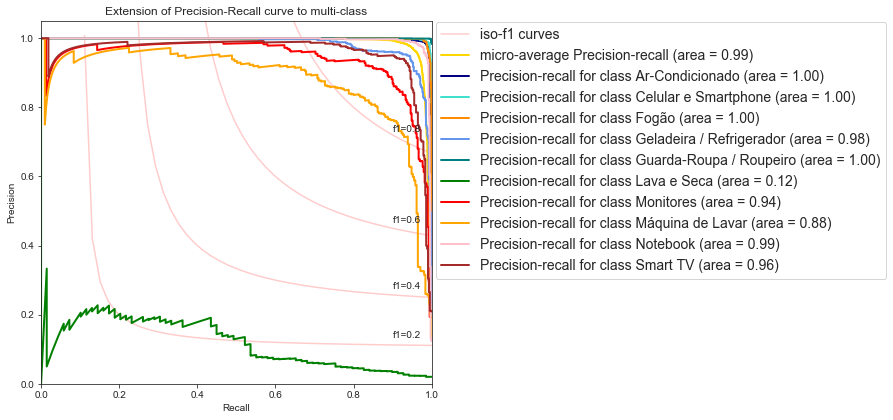

In [14]:
from itertools import cycle
# setup plot details
colors = cycle(['navy', 'turquoise', 'darkorange', 'cornflowerblue',
                'teal', 'green', 'red', 'orange', 'pink', 'brown'])

plt.figure(figsize=(7, 8))
f_scores = np.linspace(0.2, 0.8, num=4)
lines = []
labels = []
for f_score in f_scores:
    x = np.linspace(0.01, 1)
    y = f_score * x / (2 * x - f_score)
    l, = plt.plot(x[y >= 0], y[y >= 0], color='red', alpha=0.2)
    plt.annotate('f1={0:0.1f}'.format(f_score), xy=(0.9, y[45] + 0.02))

lines.append(l)
labels.append('iso-f1 curves')
l, = plt.plot(recall["micro"], precision["micro"], color='gold', lw=2)
lines.append(l)
labels.append('micro-average Precision-recall (area = {0:0.2f})'
              ''.format(average_precision["micro"]))

for i, color in zip(categories, colors):
    l, = plt.plot(recall[i], precision[i], color=color, lw=2)
    lines.append(l)
    labels.append('Precision-recall for class {0} (area = {1:0.2f})'
                  ''.format(i, average_precision[i]))

fig = plt.gcf()
fig.subplots_adjust(bottom=0.25)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Extension of Precision-Recall curve to multi-class')
plt.legend(lines, labels, loc=(1.01, 0.29), prop=dict(size=14))


plt.show()

## Intepreting the Precision-Recall Plot

As we can see the model has 91% almos 92% accuracy during testing but we have to do extra validation because the data is very unbanlanced.

The Precision-Recall curve plot helps to evaluate if the model is able to distinguish the classes.

And for all the 9 classes except `Lava e Seca` which had an area under the curve of 0.12 the models was able to learn and predict correct values.

To improve the analysis and model we could either collect more data so `Lava e Saca` accuracy increases or create a separate classifier for it.

Creating a classifier for `Lava e Seca` and evaluate if it will be better than a random guess

In [15]:
X = df.text.values
y = df.category.copy().values

y[y != 'Lava e Seca'] = 1
y[y == 'Lava e Seca'] = 0
y = y.astype('int')

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [16]:
%%time
from sklearn.metrics import classification_report

nb = train_MNB(X_train, y_train, onevsrest=False)

y_pred = nb.predict(X_test)
y_probs = nb.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred))

accuracy 0.9917637369102247
              precision    recall  f1-score   support

           0       0.33      0.01      0.03        69
           1       0.99      1.00      1.00      8430

    accuracy                           0.99      8499
   macro avg       0.66      0.51      0.51      8499
weighted avg       0.99      0.99      0.99      8499

CPU times: user 1.46 s, sys: 12 ms, total: 1.47 s
Wall time: 1.47 s


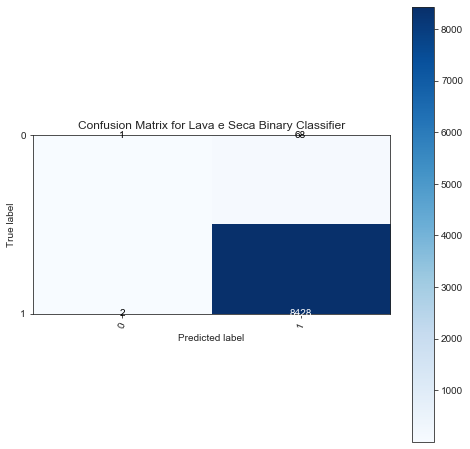

In [17]:
skplt.metrics.plot_confusion_matrix(
    y_test, 
    y_pred,
    figsize=(8,8),
    x_tick_rotation=67,
    title='Confusion Matrix for Lava e Seca Binary Classifier')

As we can see the classifier is really good at predicting classes that are not from `Lava e Seca` but it fails to recognize `Lava e Seca` examples.

## Using K-Fold Cross Validation with MNB

This strategie creates K folds/bins using the original dataset in a way that the distribution of classes in each fold is almost/exactly the same but with different examples, this helps to analyze if the classifier is performing well.

<img src="./images/cross.png" width="600" height="600">

In [18]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

# Reloading the dataset
# As we are using K-Fold cross validation
# We won't be using the onevsrest method
X = df.text
y = df.category

clf = MultinomialNB()
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', clf),
               ])

scoring = ['accuracy', 'precision_macro', 'recall_macro']

# Using K = 5
# And the precision as the scoring method
scores = cross_validate(nb, X, y, cv=10, scoring=scoring)
y_pred = cross_val_predict(nb, X, y, cv=10)

print('Accuracy Mean Score: %.3f' % np.mean(scores['test_accuracy']))
print('Precision Mean Score: %.3f' % np.mean(scores['test_precision_macro']))
print('Recall Mean Score: %.3f' % np.mean(scores['test_recall_macro']))

Accuracy Mean Score: 0.971
Precision Mean Score: 0.873
Recall Mean Score: 0.859


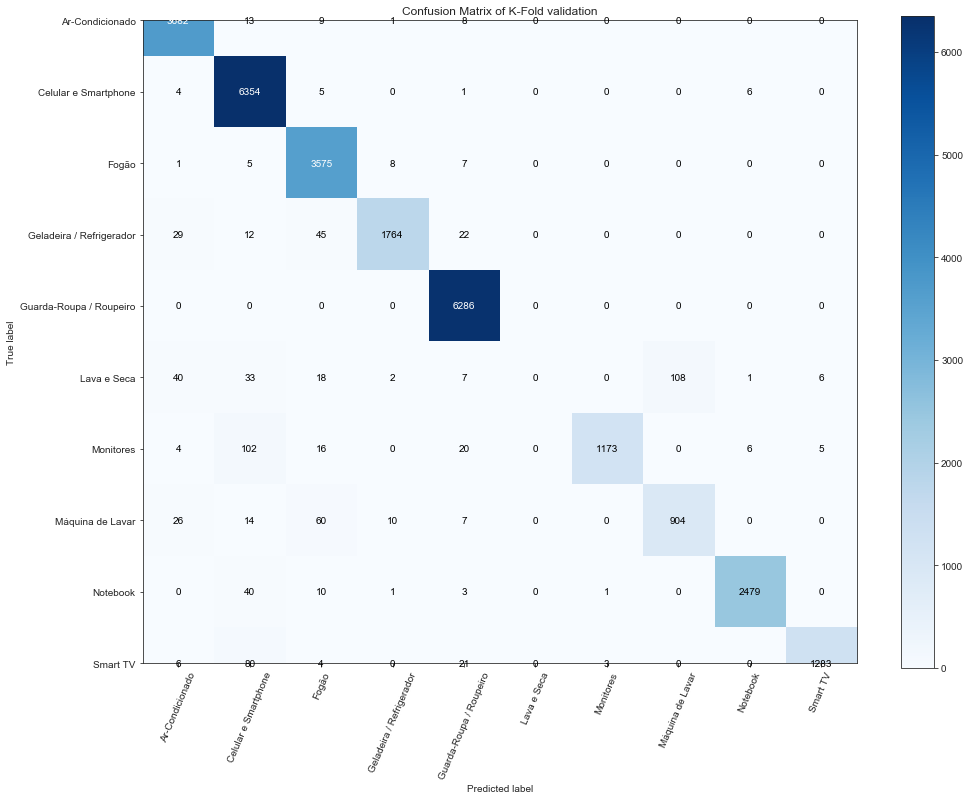

In [19]:
skplt.metrics.plot_confusion_matrix(
    y, 
    y_pred,
    figsize=(16,12),
    x_tick_rotation=67,
    title='Confusion Matrix of K-Fold validation'
)


Looking at the score results we can interpret that classifier is still not being able to distinguish the `Lava e Seca` class because it's accuracy is 96% but precision and recall scores are lower.

# Multilayer Perceptron
Multilayer perceptrons, or more commonly referred to as artificial neural networks, are a combination of multiple neurons connected in the form a network. An artificial neural network has an input layer, one or more hidden layers, and an output layer. This is shown in the image below:

<img src="./images/mlp_arch.png" width="400" height="400">

A neural network executes in two phases: Feed-Forward and Back Propagation.

## Feed-Foward

1. The values received in the input layer are multiplied with the weights. A bias is added to the summation of the inputs and weights in order to avoid null values.

2. Each neuron in the first hidden layer receives different values from the input layer depending upon the weights and bias. Neurons have an activation function that operates upon the value received from the input layer. The activation function can be of many types, like a `step function`, `sigmoid function`, `relu function`, or `tanh function`.

3. The outputs from the first hidden layer neurons are multiplied with the weights of the second hidden layer; the results are summed together and passed to the neurons of the proceeding layers. This process continues until the outer layer is reached. The values calculated at the outer layer are the actual outputs of the algorithm.


## Back Propagation

1. The error is calculated by quantifying the difference between the predicted output and the desired output. This difference is called "loss" and the function used to calculate the difference is called the "loss function". Loss functions can be of different types e.g. `mean squared error` or `cross entropy functions`. Remember, neural networks are `supervised learning` algorithms that need the desired outputs for a given set of inputs, which is what allows it to learn from the data.

2. Once the error is calculated, the next step is to minimize that error. To do so, partial derivative of the error function is calculated with respect to all the weights and biases. This is called gradient decent. The derivatives can be used to find the slope of the error function. If the slop is positive, the value of the weights can be reduced or if the slop is negative the value of weight can be increased. This reduces the overall error. The function that is used to reduce this error is called the optimization function.


The Feed-Foward and Back Propagation cycle continues until we reach the expected accuracy. Usually 90% or more is a acceptable but it depends on the  problem complexity. The overview above is a extremelly simplified. How the percepetron works and the mathematical aspects of weight and bias error minimizing are not exposed for simplicit proposal.

Now we are defining the pipeline of execution.

In [20]:
X = df.text.values
y = df.category.copy().values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42)

In [21]:
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
#hidden_layer_sizes=(10, 10, 10), max_iter=1000

def train_MLP(X_train, y_train):
    mlp = Pipeline([('vect', CountVectorizer()),
                   ('tfidf', TfidfTransformer()),
                   ('MLP', MLPClassifier(hidden_layer_sizes=(10, 10, 10), max_iter=1000)),
                   ])
    mlp.fit(X_train, y_train)
    
    return mlp

Aplying the model and getting the results

In [22]:
%%time
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler

#scaler = StandardScaler()
#scaler.fit(X_train)

#X_train = scaler.transform(X_train)
#X_test = scaler.transform(X_test)

print('Training...')
mlp = train_MLP(X_train, y_train)

y_pred_mlp = mlp.predict(X_test)
y_probs_mlp = mlp.predict_proba(X_test)

print('accuracy %s' % accuracy_score(y_pred_mlp, y_test))
print(classification_report(y_test, y_pred_mlp,target_names=categories))

Training...
accuracy 0.9817625603012119
                          precision    recall  f1-score   support

         Ar-Condicionado       0.98      0.98      0.98      1110
    Celular e Smartphone       1.00      0.99      0.99      1924
                   Fogão       1.00      0.99      1.00      1082
Geladeira / Refrigerador       0.98      0.96      0.97       546
 Guarda-Roupa / Roupeiro       1.00      1.00      1.00      1895
             Lava e Seca       0.50      0.68      0.58        69
               Monitores       0.96      0.96      0.96       390
        Máquina de Lavar       0.87      0.94      0.90       311
                Notebook       0.99      0.98      0.99       747
                Smart TV       1.00      0.97      0.98       425

                accuracy                           0.98      8499
               macro avg       0.93      0.95      0.94      8499
            weighted avg       0.98      0.98      0.98      8499

CPU times: user 3min 46s, sys: 2m

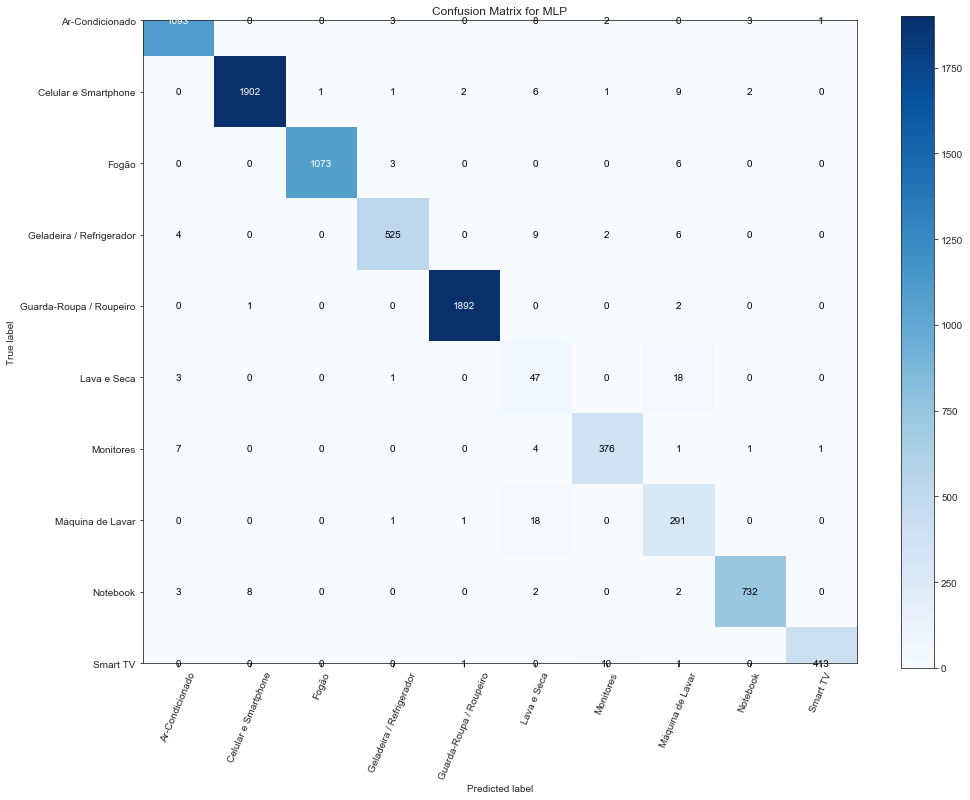

In [23]:
skplt.metrics.plot_confusion_matrix(
    y_test,
    y_pred_mlp,
    figsize=(16, 12),
    x_tick_rotation=67,
    title='Confusion Matrix for MLP')

# SVM
---

Why should we use SVM for linear classification?

In [112]:
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

## SVM
from sklearn.svm import LinearSVC
from sklearn.svm import NuSVC

In [113]:
X = df.text.values
y = df.category.copy().values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, random_state=42)

#Encoder = LabelEncoder()
#y_train = Encoder.fit_transform(y_train)
#y_test = Encoder.fit_transform(y_test)

## TF/IDF - Term Frequency/Inverse Document Frequency
---

It is a general process of turning a collection of text documents, in our case description of products, into numerical feature vector. 

* **Term Frequency**: The number of times a word appears in a document divided by the total number of words in the document. Every document has its own term frequency:

$$tf_{i,j}=\frac{n_{i,j}}{\sum_{k}n_{i,j}}$$

* **Inverse Document Frequency**: The log of the number of documents divided by the number of documents that contain the word $w$. Inverse data frequency determines the weight of rare words across all documents in the corpus:

$$idf(w)=\log(\frac{N}{df_t})$$

Lastly, the **TF/IDF** is simply the **TF** multiplied by **IDF**:

$$w_{i,j} = tf_{i,j} \cdot \frac{N}{df_i}$$



This is an [example](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html#sklearn.feature_extraction.text.TfidfVectorizer) by sklearn:
```python
	corpus = [
	     'This is the first document.',
	     'This document is the second document.',
	     'And this is the third one.',
	     'Is this the first document?',
	]
	vectorizer = TfidfVectorizer()
	X = vectorizer.fit_transform(corpus)
	
	print(vectorizer.get_feature_names())
	print(vectorizer.vocabulary_)
    print(X.shape)
```

The output:

```bash
	» ['and', 'document', 'first', 'is', 'one', 'second', 'the', 'third', 'this']
	» {'this': 8, 'is': 3, 'the': 6, 'first': 2, 'document': 1, 'second': 5, 'and': 0, 'third': 7, 'one': 4}
	» (4, 9)
```




In [114]:
def tfidf(X_train, X_test, max_features=None, _print=False):
    Tfidf_vect = TfidfVectorizer(max_features=max_features)
    Tfidf_vect.fit(df.text)

    X_tfidf_train = Tfidf_vect.transform(X_train)
    X_tfidf_test = Tfidf_vect.transform(X_test)

    if _print:
        print("Len new space: ", len(Tfidf_vect.get_feature_names()))
        print("\nFeature Names:\n", Tfidf_vect.get_feature_names()[100:120])
        
    return (X_tfidf_train, X_tfidf_test)

In [115]:
(X_train_t, X_test_t) = tfidf(X_train, X_test, _print=True)

clf = LinearSVC(random_state=42)
clf.fit(X_train_t, y_train)

y_pred = clf.predict(X_test_t)

print('\nAccuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

Len new space:  22549

Feature Names:
 ['abriu', 'abs', 'absdimensoes', 'absolut', 'absoluta', 'absolutamente', 'absolute', 'absoluto', 'absolutos', 'absorcao', 'absorva', 'absorve', 'absorvem', 'absorvendo', 'absorver', 'absorvicao', 'absorvidos', 'abstract', 'abstrato', 'abstratos']

Accuracy 0.9904694669961172
                          precision    recall  f1-score   support

         Ar-Condicionado       0.99      1.00      1.00      1110
    Celular e Smartphone       0.99      1.00      0.99      1924
                   Fogão       1.00      1.00      1.00      1082
Geladeira / Refrigerador       0.98      0.97      0.98       546
 Guarda-Roupa / Roupeiro       1.00      1.00      1.00      1895
             Lava e Seca       0.82      0.71      0.76        69
               Monitores       0.99      0.99      0.99       390
        Máquina de Lavar       0.95      0.95      0.95       311
                Notebook       1.00      0.99      0.99       747
                Smart TV

In [116]:
max_features = 22549
accuracy_score_tfidf = []
max_features_array = []

clf = LinearSVC(random_state=42)

while(max_features >= 600):
    (X_train_t, X_test_t) = tfidf(X_train, X_test, max_features=max_features)

    clf.fit(X_train_t, y_train)
    y_pred = clf.predict(X_test_t)

    accuracy_score_tfidf.append(accuracy_score(y_pred, y_test))
    max_features_array.append(max_features)
        
    max_features -= 1000

In [117]:
print(max_features_array)
print(accuracy_score_tfidf)

[22549, 21549, 20549, 19549, 18549, 17549, 16549, 15549, 14549, 13549, 12549, 11549, 10549, 9549, 8549, 7549, 6549, 5549, 4549, 3549, 2549, 1549]
[0.9904694669961172, 0.9905871278973997, 0.9904694669961172, 0.9907047887986822, 0.9904694669961172, 0.9904694669961172, 0.9904694669961172, 0.9905871278973997, 0.9905871278973997, 0.9904694669961172, 0.9907047887986822, 0.9899988233909872, 0.9904694669961172, 0.9903518060948346, 0.9899988233909872, 0.9902341451935521, 0.9904694669961172, 0.9903518060948346, 0.9905871278973997, 0.9899988233909872, 0.9890575361807271, 0.9884692316743147]


<IPython.core.display.Javascript object>


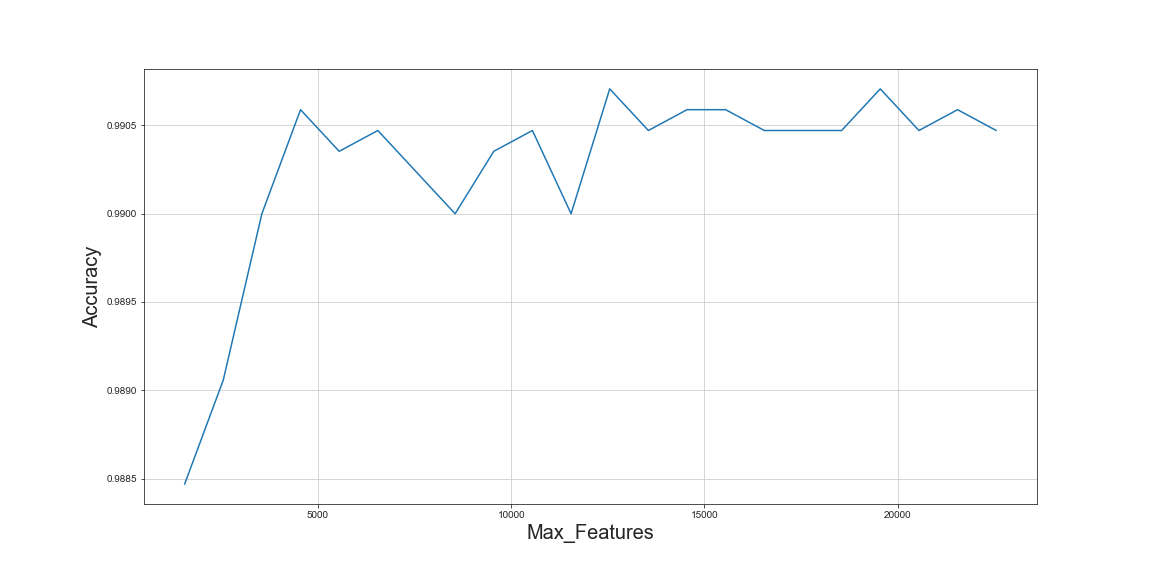

In [118]:
plt.figure(figsize=(16,8))
plt.plot(max_features_array, accuracy_score_tfidf)
plt.grid(True)
plt.xlabel("Max_Features", fontsize=20)
plt.ylabel("Accuracy", fontsize=20)
plt.show()

In [119]:
(X_train_t, X_test_t) = tfidf(X_train, X_test, max_features=min(max_features_array), _print=True)

clf = LinearSVC(random_state=42)
clf.fit(X_train_t, y_train)

y_pred = clf.predict(X_test_t)

print('\nAccuracy %s' % accuracy_score(y_pred, y_test))
print(classification_report(y_test, y_pred,target_names=categories))

Len new space:  1549

Feature Names:
 ['armazenar', 'armyshield', 'arquivos', 'arranhoes', 'artes', 'artificial', 'as', 'aspire', 'assim', 'assista', 'assistencia', 'assistir', 'atencao', 'atender', 'atendidos', 'atendimento', 'atente', 'aterramento', 'atinge', 'ativado']

Accuracy 0.9884692316743147
                          precision    recall  f1-score   support

         Ar-Condicionado       0.99      0.99      0.99      1110
    Celular e Smartphone       0.99      1.00      1.00      1924
                   Fogão       0.99      1.00      0.99      1082
Geladeira / Refrigerador       0.98      0.97      0.97       546
 Guarda-Roupa / Roupeiro       1.00      1.00      1.00      1895
             Lava e Seca       0.79      0.64      0.70        69
               Monitores       0.98      0.98      0.98       390
        Máquina de Lavar       0.93      0.95      0.94       311
                Notebook       1.00      0.99      0.99       747
                Smart TV       0.99  

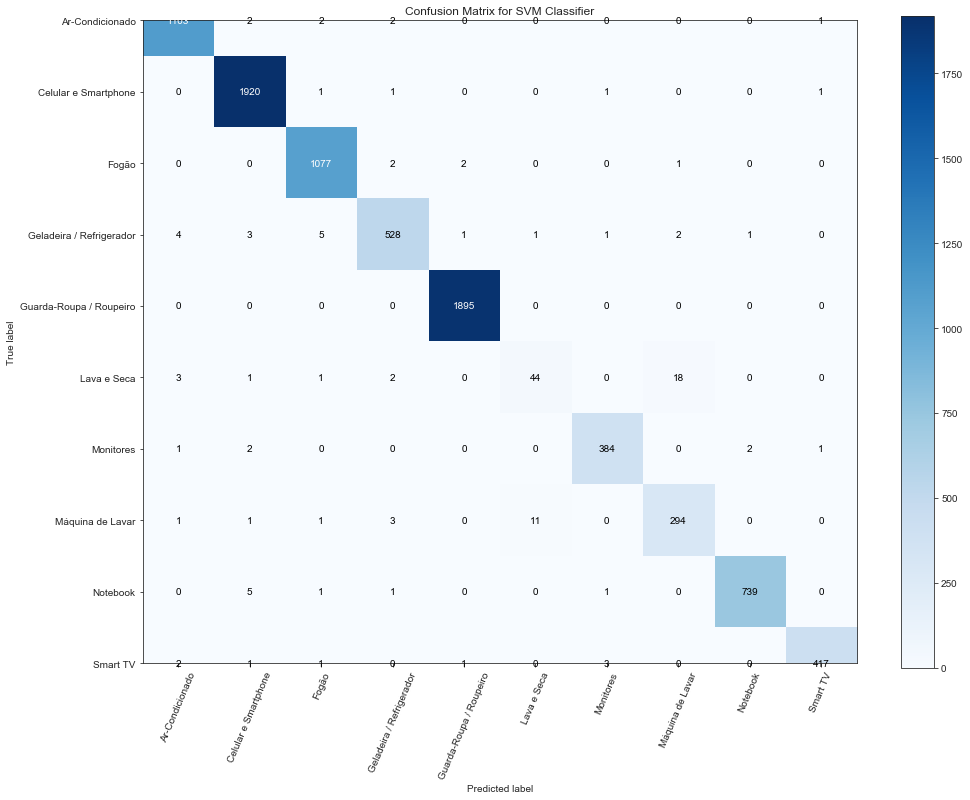

In [123]:
skplt.metrics.plot_confusion_matrix(
    y_test,
    y_pred,
    figsize=(16, 12),
    x_tick_rotation=67,
    title='Confusion Matrix for SVM Classifier')